In [1]:
import numpy as np
import keras
import sys
import os, glob
from keras.models import Model
import tensorflow as tf
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from IPython.display import clear_output
import tqdm 
import math

sys.path.append('../src')

from util import get_model_by_name

from sal_imp_utilities import *
from cb import InteractivePlot

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
%%bash
nvidia-smi

Mon May  9 14:27:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:29:00.0  On |                  N/A |
| 30%   41C    P2    38W / 184W |   1027MiB /  7959MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

# ENV

In [4]:
data_path = '/your/path/VisRecall/'
# 0: T, 1: FE, 2: F, 3: RV, 4: U
TYPE = 0
split = 0

# Load data

In [5]:
TYPE_Q = ['T','FE','F','RV','U']
bp_imp = data_path + 'merged/src/'
training_set = np.load(data_path + 'training_data/%s-question/train_split%d.npy'%(TYPE_Q[TYPE], split),allow_pickle=True)
val_set = np.load(data_path + 'training_data/%s-question/val_split%d.npy'%(TYPE_Q[TYPE], split),allow_pickle=True)

In [6]:
train_filename = []
train_label = []
train_mean = []
train_type = []

for data in training_set:
    one_hot = [0,0,0,0,0,0]
    one_hot[data['vistype']] = 1
    train_filename.append(bp_imp+data['name'])
    train_label.append(one_hot)
    train_mean.append(data['norm_mean_acc_withD'])
    train_type.append(data['norm_%d_withD'%(TYPE)])


In [7]:
val_filename = []
val_label = []
val_mean = []
val_type = []
for data in val_set:
    one_hot = [0,0,0,0,0,0]
    one_hot[data['vistype']] = 1
    val_filename.append(bp_imp+data['name'])
    val_label.append(one_hot)
    val_mean.append(data['norm_mean_acc_withD'])
    val_type.append(data['norm_%d_withD'%(TYPE)])
#val_filename

# Model and training params

In [8]:
# FILL THESE IN: set training parameters 
ckpt_savedir = "ckpt"

load_weights = False
weightspath = ""

batch_size = 4
init_lr = 0.002
lr_reduce_by = .1
reduce_at_epoch = 3
n_epochs = 15

opt = Adam(lr=init_lr) 


model_name = "RecallNet_xception"

model_inp_size = (240, 320)

In [9]:
input_shape = model_inp_size + (3,)

In [10]:
# get model 
model_params = {
    'input_shape': input_shape,
    #'n_outs': len(losses),
    'n_outs': 2
}
model_func, mode = get_model_by_name(model_name)
#assert mode == "simple", "%s is a multi-duration model! Please use the multi-duration notebook to train." % model_name
model = model_func(**model_params)

if load_weights: 
    model.load_weights(weightspath)
    print("load")


xception output shapes: (?, 30, 40, 2048)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 159, 32) 0           block1_conv1_bn[0][0]            
_________________________________________________

In [11]:
# set up data generation and checkpoints
if not os.path.exists(ckpt_savedir): 
    os.makedirs(ckpt_savedir)


# Generators
gen_train = RecallNet_Generator(train_filename,
                           train_label,
                           train_mean,
                           train_type,
                           batch_size = 4)

gen_val = RecallNet_Generator(val_filename,
                           val_label,
                           val_mean,
                           val_type,
                           1)

# Callbacks

# where to save checkpoints
#filepath = os.path.join(ckpt_savedir, dataset_sal + "_" + l_str + '_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5')
filepath = os.path.join(ckpt_savedir, model_name, model_name+'_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5')

print("Checkpoints will be saved with format %s" % filepath)

cb_chk = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, period=1)
cb_plot = InteractivePlot()

def step_decay(epoch):
    lrate = init_lr * math.pow(lr_reduce_by, math.floor((1+epoch)/reduce_at_epoch))
    if epoch%reduce_at_epoch:
        print('Reducing lr. New lr is:', lrate)
    return lrate
cb_sched = LearningRateScheduler(step_decay)

cbs = [cb_chk, cb_sched, cb_plot]

Checkpoints will be saved with format ckpt/RecallNet_xception/RecallNet_xception_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5


In [12]:
#test the generator 
batch_img, out= gen_train.__getitem__(1)
print(out)

[array([0.74688797, 0.84647303, 0.93360996, 0.8340249 ]), array([0.7826087 , 0.95652174, 1.        , 0.86956522])]


# Train

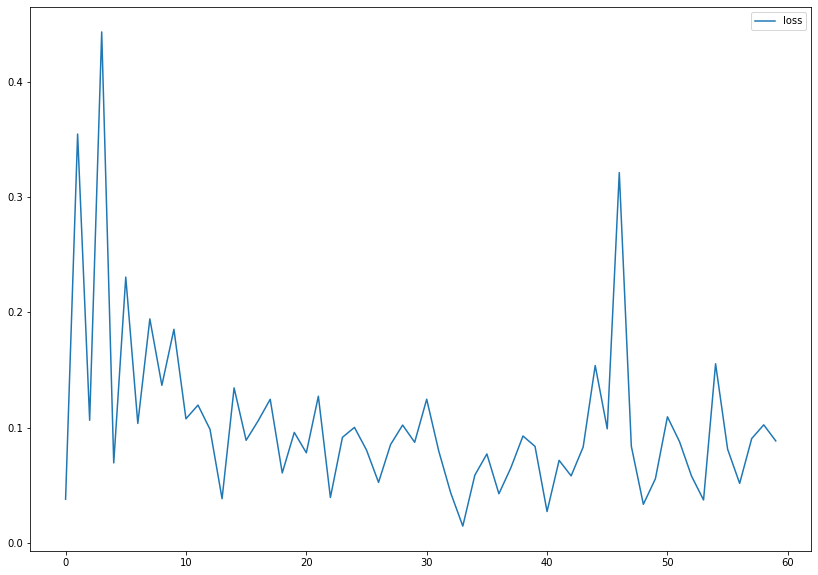

In [14]:
#model.compile(optimizer=opt, loss={'out_mean_acc': 'mean_squared_error', 'out_type0_acc':'mean_squared_error','out_classif':'binary_crossentropy'}, loss_weights={'out_mean_acc': 3, 'out_type0_acc': 3, 'out_classif': 1})
model.compile(optimizer=opt, loss={'out_mean_acc': 'mean_squared_error', 'out_type0_acc':'mean_squared_error'}, loss_weights={'out_mean_acc': 1, 'out_type0_acc': 1})

print('Ready to train')
model.fit_generator(gen_train, epochs=n_epochs, verbose=1, callbacks=cbs, validation_data=gen_val, max_queue_size=10, workers=5)

## validation

In [77]:
data_path = '/your/path/VisRecall/'

if True:
    W = "./ckpt/RecallNet/U-question/Fold4/RecallNet_xception_ep10_valloss0.0313.hdf5"
    model.load_weights(W)
    print('load')

load


In [78]:
from sklearn.metrics import mean_squared_error

mean_list = []
type_list = []

num_t = 0.0

for i in range(len(val_filename)):
    img = preprocess_images([val_filename[i]], 240, 320)
    preds = model.predict(img)
    #if(np.argmax(preds[2][0]) == np.argmax(val_label[i])):
    #    num_t += 1
    mean_acc = preds[0][0]
    type_acc = preds[1][0]
    mean_list.append(mean_squared_error([val_mean[i]], mean_acc))
    type_list.append(mean_squared_error([val_type[i]], type_acc))
    #print(val_label[i])

#print('classificaion: ', num_t/len(val_filename))
print('avg, type: ', np.mean(mean_list),np.mean(type_list))


avg, type:  0.02553353417062307 0.02617591625785007


In [13]:
from sklearn.metrics import mean_squared_error

In [24]:
# 0: T, 1: FE, 2: F, 3: RV, 4: U
TYPE = 4
final = []
for split in range(5):
    TYPE_Q = ['T','FE','F','RV','U']
    bp_imp = data_path + 'merged/src/'
    training_set = np.load(data_path + 'training_data/%s-question/train_split%d.npy'%(TYPE_Q[TYPE], split),allow_pickle=True)
    val_set = np.load(data_path + 'training_data/%s-question/val_split%d.npy'%(TYPE_Q[TYPE], split),allow_pickle=True)
    train_filename = []
    train_label = []
    train_mean = []
    train_type = []

    for data in training_set:
        one_hot = [0,0,0,0,0,0]
        one_hot[data['vistype']] = 1
        train_filename.append(bp_imp+data['name'])
        train_label.append(one_hot)
        train_mean.append(data['norm_mean_acc_withD'])
        train_type.append(data['norm_%d_withD'%(TYPE)])
    
    val_filename = []
    val_label = []
    val_mean = []
    val_type = []
    for data in val_set:
        one_hot = [0,0,0,0,0,0]
        one_hot[data['vistype']] = 1
        val_filename.append(bp_imp+data['name'])
        val_label.append(one_hot)
        val_mean.append(data['norm_mean_acc_withD'])
        val_type.append(data['norm_%d_withD'%(TYPE)])

    mean_list = []
    type_list = []

    num_t = 0.0
    if True:
        W = "./ckpt/RecallNet_xception/U-question/Fold"+str(split)+"/RecallNet_xception_ep10.hdf5"
        model.load_weights(W)
        print('load')

    for i in range(len(val_filename)):
        img = preprocess_images([val_filename[i]], 240, 320)
        preds = model.predict(img)
        #if(np.argmax(preds[2][0]) == np.argmax(val_label[i])):
        #    num_t += 1
        mean_acc = preds[0][0]
        type_acc = preds[1][0]
        mean_list.append(mean_squared_error([val_mean[i]], mean_acc))
        type_list.append(mean_squared_error([val_type[i]], type_acc))
    final.append((np.mean(mean_list),np.mean(type_list)))
    print(final)

load
[(0.1154690275375791, 0.07620564377135046)]
load
[(0.1154690275375791, 0.07620564377135046), (0.10878741427577963, 0.2667425108749781)]
load
[(0.1154690275375791, 0.07620564377135046), (0.10878741427577963, 0.2667425108749781), (0.5932855723937102, 0.38129302771926993)]
load
[(0.1154690275375791, 0.07620564377135046), (0.10878741427577963, 0.2667425108749781), (0.5932855723937102, 0.38129302771926993), (0.015003968232081454, 0.06507362662601399)]
load
[(0.1154690275375791, 0.07620564377135046), (0.10878741427577963, 0.2667425108749781), (0.5932855723937102, 0.38129302771926993), (0.015003968232081454, 0.06507362662601399), (0.02553353417062307, 0.02617591625785007)]


In [25]:
np.mean(final ,axis=0),np.std(final ,axis=0)

(array([0.1716159 , 0.16309815]), array([0.21483601, 0.13730111]))

## Test

In [36]:
#W_T = "./ckpt/VMQA_UMSI/T-question/UMSI_weight1:1/Fold0/VMQA_UMSI_ep10_valloss0.6198.hdf5"
W_T = "./ckpt/RecallNet_xception/T-question/Fold4/RecallNet_xception_ep10.hdf5"

model.load_weights(W_T)

image_path = "/your/path/to/src"
list_img_targets = glob.glob(image_path + '/*.png')
print(list_img_targets)
images = preprocess_images(list_img_targets, model_inp_size[0], model_inp_size[1])


['/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/bar4.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/pie4.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/bar1.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/pie2.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/bar3.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/line1.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/bar2.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/pie1.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/line2.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/line4.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/src/line3.png', '/netpool/homes/wangyo/Projects/2020_luwei_VisQA/Dataset/application/sr

In [37]:
preds_recallNet = model.predict(images)

In [38]:
print(preds_recallNet[0].shape, preds_recallNet)

(12, 1) [array([[0.6729137 ],
       [0.62224036],
       [0.6644782 ],
       [0.63536835],
       [0.6595377 ],
       [0.6628296 ],
       [0.600067  ],
       [0.64756936],
       [0.600191  ],
       [0.6459451 ],
       [0.6242438 ],
       [0.60450727]], dtype=float32), array([[0.7803583 ],
       [0.67262685],
       [0.75816834],
       [0.718869  ],
       [0.7442306 ],
       [0.76404536],
       [0.8003189 ],
       [0.7172563 ],
       [0.7985541 ],
       [0.81216127],
       [0.6953638 ],
       [0.6564585 ]], dtype=float32)]
